# DBN Structure Inference

The idea is to infer a posterior for the *structure* of a Dynamic Bayesian Network (DBN), given some data.

We formulate this task with the following model:

$$ P(G | X) \propto P(X | G) \cdot P(G) $$

* $P(G)$ is a prior distribution over DBN structures. We'll assume it has the form
$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$
where $|G \setminus G^\prime|$ denotes the number of edges in the graph, which are not present in some reference graph $G^\prime$.
* $P(X | G)$ is the marginal likelihood of the DBN structure. That is, it's the likelihood of the DBN after the network parameters have been integrated out -- it scores network *structure*. 
* If we assume some reasonable priors for network parameters, $P(X|G)$ can be obtained in closed form. In this work, we'll use the following marginal likelihood:
    
    $$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$ 
    where $X$ and $B$ are matrices obtained from data; and $n$ is the total number of timesteps in the dataset. This marginal likelihood results from an empirical prior over the regression coefficients, and an improper ($\propto 1/\sigma^2$) prior for the regression "noise" variables.

## Get some data

For now, we'll work with some data used by Hill et al. in their 2012 paper, _Bayesian Inference of Signaling Network Topology in a Cancer Cell Line_.

It gives the differential phosphorylation levels of 20 proteins, in a cancer cell line perturbed by EGF. This is a well-studied signaling pathway; the goal is to produce a graph describing the dependencies between proteins in this pathway. 

NOTE: I have confirmed that the ordering of proteins in `protein_vec` is identical to the ordering in the columns of `timeseries_data`. So we can depend on that.

## Build the model

Implement the graph prior distribution:

$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$

Implement the DBN's marginal distribution:

$$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$

Some things to note:
* We're kind of shoe-horning this marginal likelihood into Gen. The probabilistic programming ethos entails modeling the entire data-generating process. This ought to provide better performance during inference, though.

A BUNCH OF HELPER FUNCTIONS:

THE MARGINAL LIKELIHOOD DISTRIBUTION

## Inference

### Metropolis-Hastings over directed graphs

Proposal distribution:

Involution function:

### Our inference program

# TESTING THE NEW MODEL

In [1]:
using Gen
using GLMNet
include("PSDiGraph.jl")
using .PSDiGraphs
include("dbn_preprocessing.jl")
include("dbn_models.jl")
include("dbn_proposals.jl")
include("dbn_inference.jl")
using PyPlot
using Profile
using ProfileView

In [2]:
timeseries_data_path = "data/mukherjee_data.csv"
protein_names_path = "data/protein_names.csv"
reference_adj_path = "data/prior_graph.csv"
timesteps_path = "data/time.csv"

"data/time.csv"

In [3]:
(timeseries_vec, protein_vec, ref_adj, timesteps) = hill_2012_preprocess(timeseries_data_path, 
                                                                         protein_names_path, 
                                                                         reference_adj_path, 
                                                                         timesteps_path);

In [4]:
Gen.load_generated_functions()

In [9]:
clear_caches()
regression_deg = 4
phi_ratio = 1.0
lambda_prior_param = 0.25
n_samples = 100
fixed_lambda = 3.0
burnin = 10
thinning = 25
lambda_r = 0.5
median_degs = [1.0*sum(ps) for ps in ref_adj];

edge_posterior, lambdas, lambda_accs, ps_accs = dbn_vertexwise_inference(ref_adj, 
                                                                         timeseries_vec, 
                                                                         regression_deg,
                                                                         phi_ratio,
                                                                         lambda_prior_param,
                                                                         n_samples, 
                                                                         burnin, 
                                                                         thinning, 
                                                                         lambda_r, 
                                                                         median_degs,
                                                                         fixed_lambda,
                                                                         false)

([0.29 0.81 … 0.0 0.02; 0.31 1.0 … 0.02 0.02; … ; 0.0 0.04 … 0.21 0.02; 0.42 0.37 … 0.0 0.21], [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0  …  3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0], 0.0, [0.2209255533199195, 0.23219315895372233, 0.15653923541247486, 0.1806841046277666, 0.22293762575452716, 0.16619718309859155, 0.22012072434607646, 0.18108651911468812, 0.2140845070422535, 0.1818913480885312, 0.2973843058350101, 0.20603621730382293, 0.2370221327967807, 0.18309859154929578, 0.22615694164989938, 0.16780684104627766, 0.2800804828973843, 0.2776659959758551, 0.2748490945674044, 0.27002012072434606])

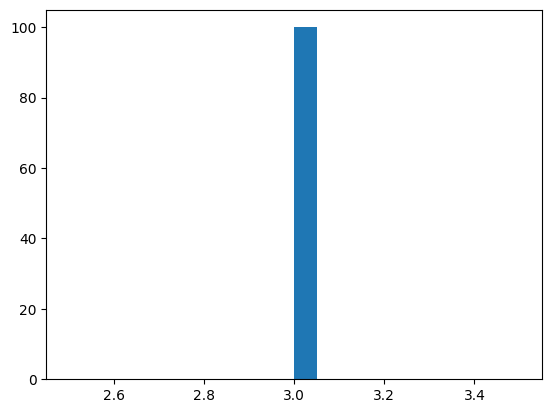

In [6]:
hist(lambdas, bins=20)
show()

In [10]:
transpose(edge_posterior)

20×20 Transpose{Float64,Array{Float64,2}}:
 0.29  0.31  0.0   0.7   0.02  0.43  …  0.14  0.01  0.02  0.03  0.0   0.42
 0.81  1.0   0.25  0.05  0.01  0.88     0.28  0.1   0.02  0.02  0.04  0.37
 0.0   0.02  0.21  0.01  0.19  0.02     0.15  0.56  0.01  0.05  0.64  0.3 
 0.0   0.03  0.0   0.35  0.02  0.06     0.03  0.02  0.0   0.04  0.21  0.06
 0.11  0.2   0.27  0.02  0.96  0.23     0.01  0.77  0.22  0.2   0.21  0.0 
 0.01  0.01  0.0   0.03  0.02  0.99  …  0.0   0.01  0.04  0.01  0.01  0.14
 0.0   0.01  0.12  0.4   0.04  0.0      0.02  0.1   0.02  0.05  0.01  0.03
 0.08  0.03  0.58  0.01  0.01  0.96     0.03  0.02  0.02  0.02  0.01  0.94
 0.02  0.0   0.1   0.08  0.03  0.06     0.01  0.92  0.98  0.09  0.0   0.35
 0.0   0.01  0.01  0.01  0.03  0.09     0.0   0.01  0.02  0.0   0.0   0.07
 0.2   0.21  0.01  0.04  0.0   0.01  …  0.02  0.0   0.3   0.18  0.38  0.01
 0.02  0.01  0.09  0.01  0.01  0.01     0.0   0.0   0.01  0.01  0.03  0.03
 0.01  0.02  0.03  0.15  0.23  0.02     0.04  0.02  0.37 

In [8]:
hill_result = convert(Matrix{Float64}, CSV.read("data/edge_prob_matrix.csv"))

20×20 Array{Float64,2}:
 0.11084      0.122596     0.0379205    …  0.178552     0.0571664 
 0.950869     0.997652     0.174526        0.0104266    0.0449605 
 0.00475166   0.00148091   0.0704487       0.147554     0.0489659 
 0.00202306   0.00288393   0.00267562      0.0354861    0.00867835
 0.0196006    0.0426981    0.37382         0.437884     0.00142491
 0.00827803   0.00205783   0.000807644  …  0.000931571  0.0301194 
 0.0493155    0.00467234   0.00351954      0.0112605    0.0049895 
 0.0165201    0.00867707   0.268574        0.00103685   0.950199  
 0.0046717    0.00573582   0.128029        0.000824887  0.0761773 
 0.00333868   0.00139212   0.00388568      0.00624058   0.00295872
 0.0224456    0.0333688    0.00113784   …  0.0199791    0.00190399
 0.00156734   0.00933485   0.0998421       0.000937629  0.00211683
 0.00133807   0.00440722   0.00897539      0.00408237   0.00513697
 0.0259144    0.00207317   0.310454        0.00282329   0.0326157 
 0.0305407    0.0161301    0.0181118  

In [11]:
hill_result[:,5]

20-element Array{Float64,1}:
 0.04151771044803633  
 0.02618837309200779  
 0.06469924628671361  
 0.006317747411607069 
 0.994298928558952    
 0.0022928764635395346
 0.004484527186363329 
 0.0014488303810443158
 0.0018843036111529483
 0.006152936519921729 
 0.0012279665208409843
 0.0010992287856416972
 0.16707381579417158  
 0.01963621878837054  
 0.007468221996292591 
 0.056445509091101326 
 0.0038425029099626077
 0.003169592984620425 
 0.007622028367872339 
 0.0053734216081560305

In [ ]:
function phi_ratio_schedule(t::Float64)
    return 1.0 / (1.0 + exp(-30.0*(t - 0.5)))
end

In [ ]:
t = collect(0.0:0.01:1.0)
pr = [phi_ratio_schedule(t0) for t0 in t]
plot(t, pr)
show()

In [ ]:
clear_caches()
#Profile.clear()

#@profile edge_posterior, ps_accs = dbn_edgeind_annealing_inference(ref_adj, 
edge_posterior, ps_accs = dbn_edgeind_annealing_inference(ref_adj,
                                                          timeseries_vec, 
                                                          regression_deg,
                                                          phi_ratio_schedule,
                                                          fixed_lambda,
                                                          n_samples,
                                                          thinning,  
                                                          median_degs)

In [ ]:
transpose(edge_posterior)

In [ ]:
hill_result

In [ ]:
typeof(Gen.NoChange())

In [ ]:
clear_caches()

In [ ]:
ProfileView.view()

In [ ]:
clear_caches()
burnin = 20
thinning = 20
n_samples = 10
Profile.clear()
#@profile edge_posterior, edge_accs = dbn_edgeind_gibbs_inference(ref_adj, 
edge_posterior, edge_accs = dbn_edgeind_gibbs_inference(ref_adj,
                                                        timeseries_vec, 
                                                        regression_deg,
                                                        phi_ratio,
                                                        fixed_lambda,
                                                        n_samples,
                                                        burnin,
                                                        thinning)

In [ ]:
edge_posterior

In [ ]:
ProfileView.view()

In [ ]:
[[3]; [true for i=1:10]]

In [ ]:
sum([true for i=1:10])

In [ ]:
using Pkg

In [ ]:
Pkg.add("FunctionalCollections")

In [ ]:
using FunctionalCollections

In [ ]:
v = PersistentVector{Float64}()

In [ ]:
y = convert(Vector{Float64}, v)

In [ ]:
v = PersistentVector{Float64}([1.0, 2.0, 3.0])

In [ ]:
y = Vector{Float64}([x for x in v])

In [ ]:
Bool(1)

In [ ]:
timeseries_vec

In [ ]:
t = convert(Matrix{Float64}, timesteps)
t = t[1,:]

In [ ]:
# for ts_array in timeseries_vec
#     plot(t, ts_array)
for ts_array in timeseries_vec
    plot(t, ts_array, linewidth=0.5)
end
xlim(5,240)
#yscale("log")
show()